# Training Resnet18 to recognize smiling faces

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
import torch
from torchvision import *

In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)

## Data Augmentation

In [4]:
path = './data/happyunhappy/'

In [5]:
tfms = get_transforms(max_lighting=0.3, max_rotate=30, max_zoom=0, do_flip=True, flip_vert=False, max_warp=0.2, \
                      p_affine=0.75, p_lighting=0.75)

In [7]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)
data.normalize(imagenet_stats)

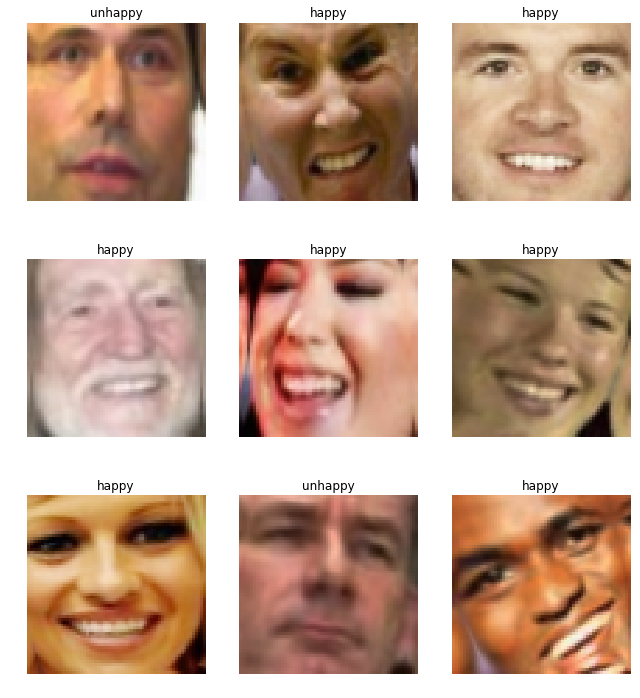

In [8]:
data.show_batch(3)

In [9]:
learn = create_cnn(data, models.resnet18, pretrained=True, metrics=[accuracy])

In [10]:
learn.lr_find()
learn.recorder.plot()

  File "/home/matt/.conda/envs/happy/lib/python3.6/multiprocessing/queues.py", line 99, in get
    if not self._rlock.acquire(block.all(), timeout):
AttributeError: 'bool' object has no attribute 'all'
AttributeError: 'bool' object has no attribute 'all'
Process Process-1:
Traceback (most recent call last):
  File "/home/matt/.conda/envs/happy/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/matt/.conda/envs/happy/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matt/.conda/envs/happy/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 124, in _worker_loop
    r = index_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/matt/.conda/envs/happy/lib/python3.6/multiprocessing/queues.py", line 99, in get
    if not self._rlock.acquire(block.all(), timeout):
AttributeError: 'bool' object has no attribute 'all'


LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: DataLoader worker (pid 11149) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

In [ ]:
interp.plot_top_losses(4, figsize=(7, 7), largest=True)

In [ ]:
interp.plot_top_losses(4, figsize=(7, 7), largest=False)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.save('happy_aug')

## Fine-Tuning 

In [ ]:
learn.load('happy_aug')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

In [ ]:
interp.plot_top_losses(9, largest=True)

In [ ]:
interp.plot_top_losses(9, largest=False)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.save('happy_aug_ft')

## Convert to onnx

In [ ]:
from torch.autograd import Variable
import torch.onnx
import torchvision
import os
import onnx

In [ ]:
learn.load('happy_aug')

In [ ]:
dummy_input = Variable(torch.randn(64, 3, 64, 64))
input_names = [ "actual_input_1" ]
output_names = [ "output1" ]

In [ ]:
if not os.path.isdir('./onnx_models/'):
    os.mkdir('./onnx_models/')
    
torch.onnx.export(learn.model,dummy_input,'./onnx_models/happy2.onnx', verbose=True, \
                  input_names=input_names, output_names=output_names)